### **Завдання**:
### 1. Дослідити дані в датасеті
### 2. Натренувати та оцініти модель класифікатора
### 3. Збалансувати класи в таргеті за допомогою різних методів та визначити найкращий варіант для завдання класификації.

In [ ]:
# !pip install imbalanced-learn

In [ ]:
# Import all required libraries
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import TomekLinks, CondensedNearestNeighbour
from imblearn.over_sampling import SMOTEN, ADASYN, RandomOverSampler
from imblearn.combine import SMOTEENN, SMOTETomek

# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **1. Read and Analize datasets**

In [ ]:
# Read the dataset
file_path = '/content/drive/MyDrive/Datasets/glass/data.csv'
df = pd.read_csv(file_path, index_col='Id_number')
df.head(3)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type_of_glass
Id_number,,,,,,,,,,
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 214 entries, 1 to 214
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RI             214 non-null    float64
 1   Na             214 non-null    float64
 2   Mg             214 non-null    float64
 3   Al             214 non-null    float64
 4   Si             214 non-null    float64
 5   K              214 non-null    float64
 6   Ca             214 non-null    float64
 7   Ba             214 non-null    float64
 8   Fe             214 non-null    float64
 9   Type_of_glass  214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 18.4 KB


In [ ]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type_of_glass
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


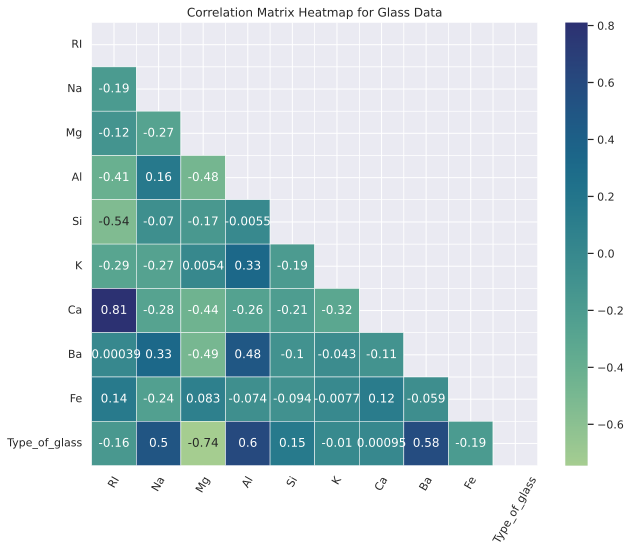

In [ ]:
# Generate a correlation matrix and visualize possible correlations between all numerical columns
correlation_matrix_1 = df.corr()
mask1 = np.triu(correlation_matrix_1)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_1, annot=True, cmap='crest', linewidths=0.5, mask=mask1)
plt.title('Correlation Matrix Heatmap for Glass Data')
plt.xticks(rotation=60)
plt.yticks(rotation=0)
plt.show()

* **Спостерігаємо міцну позитивну кореляцію таргету *'Type_of_glass'* з призначками *'Na'*, *'Al'*, *'Ba'* та негативну кореляцію з кількома іншими признаками. Це вказує на те що в нас гарні шанси на якісне навчання моделі.**
* **Щоб впевнитися в цьому побудуємо графік взаємозвязків та розподілу значень**

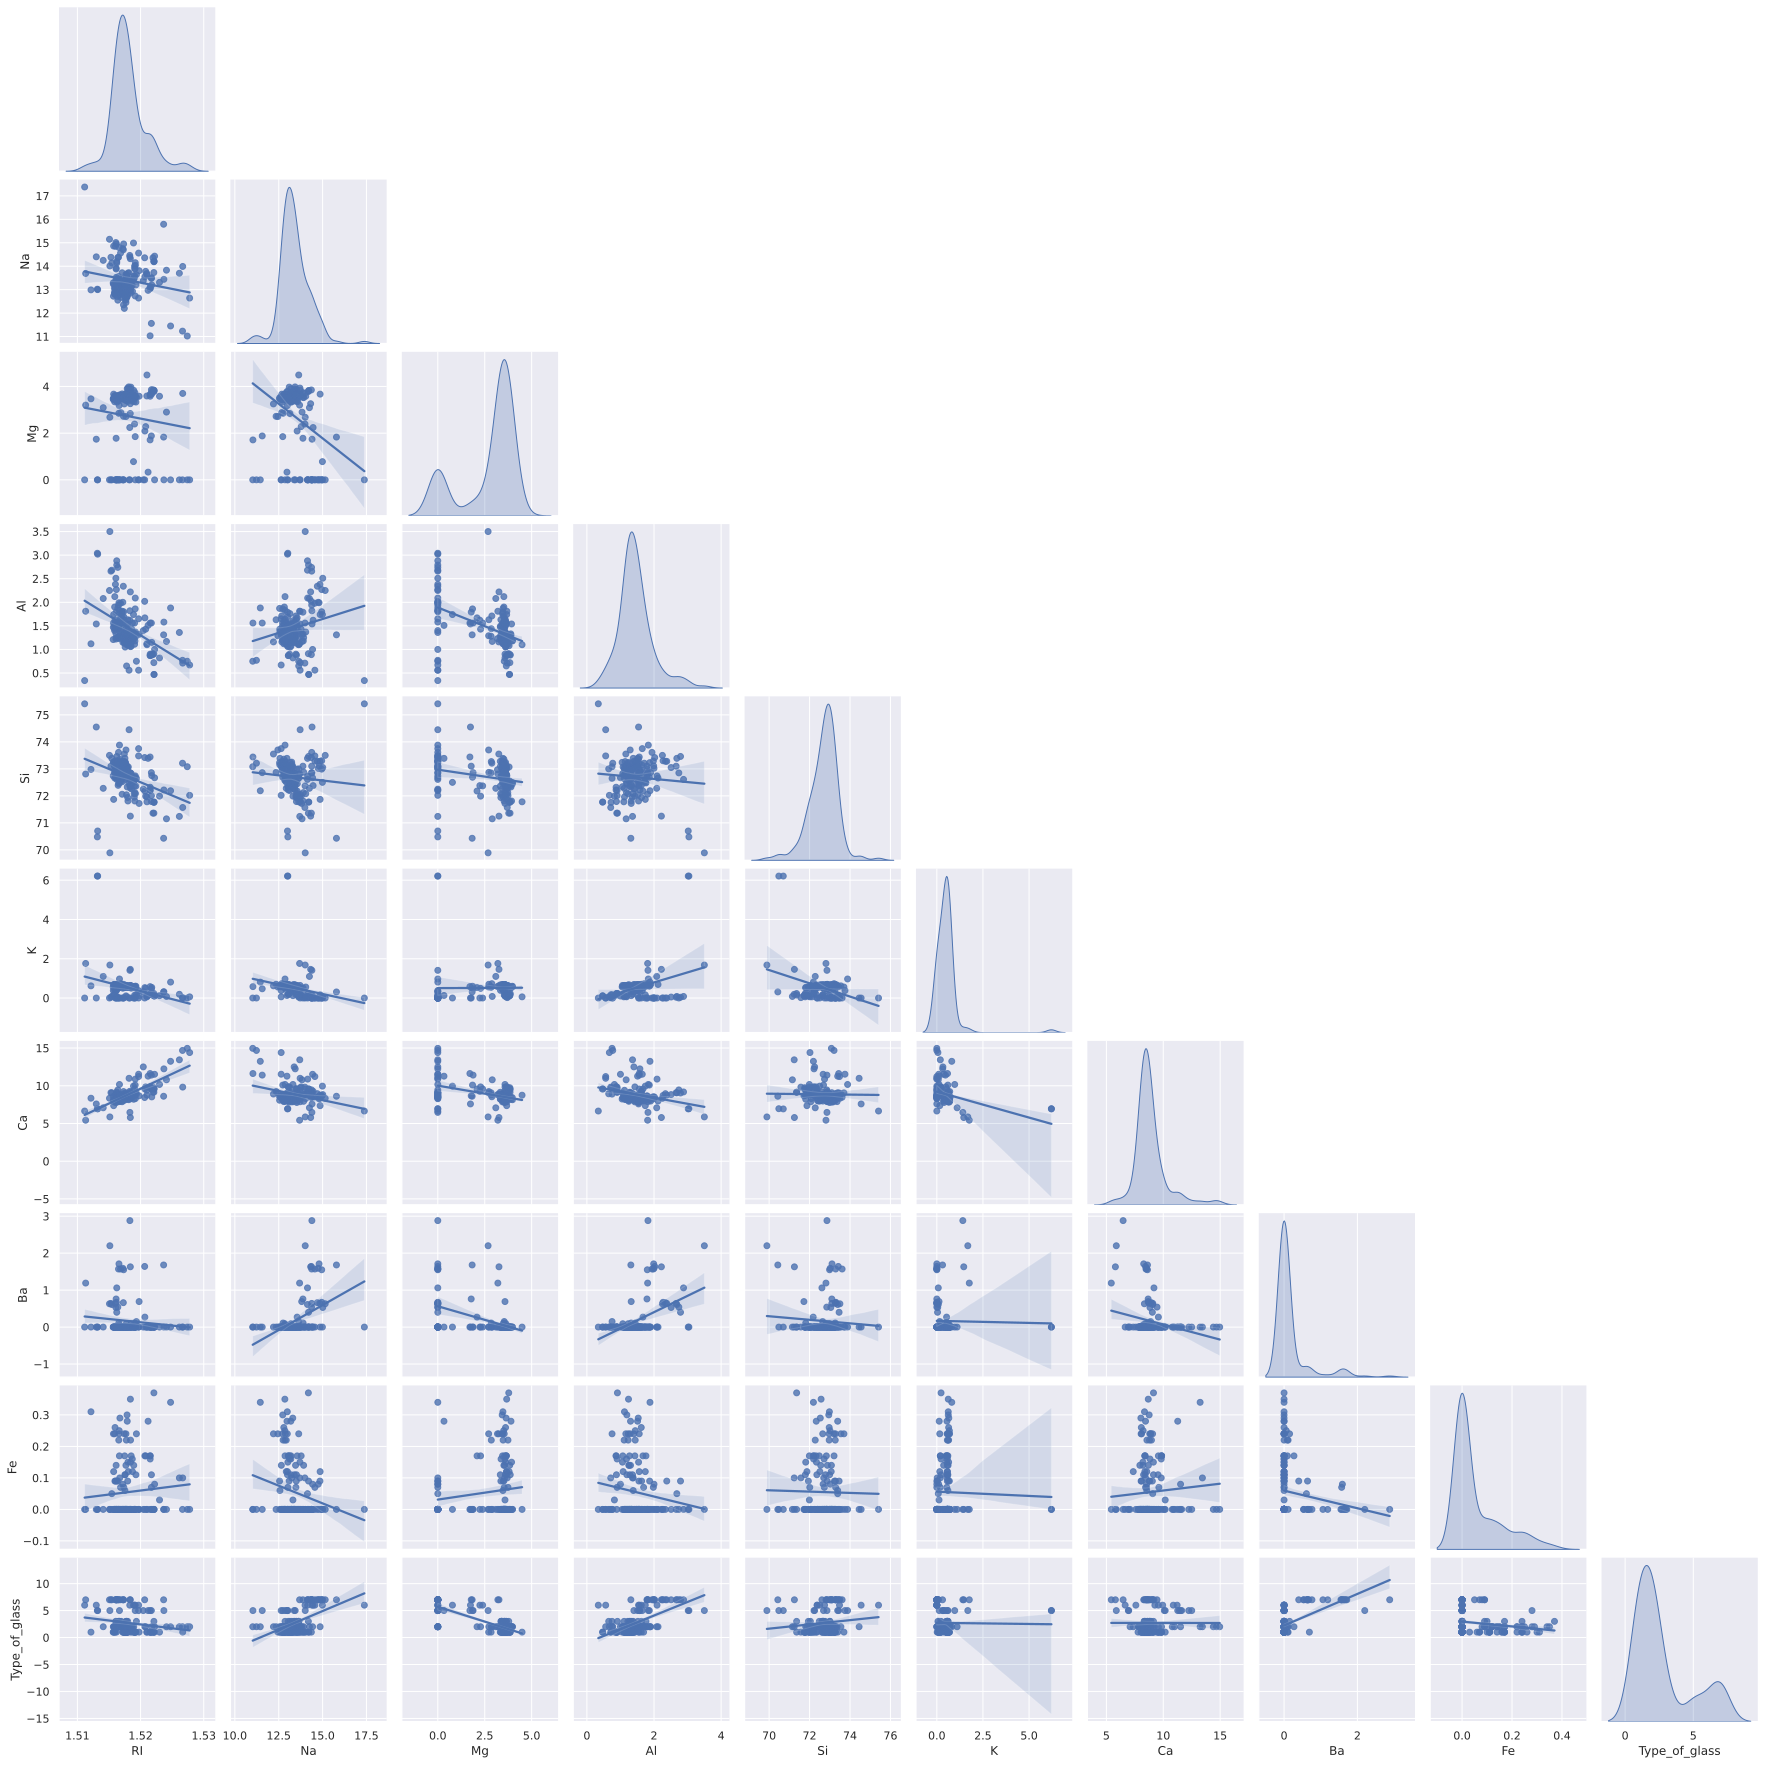

In [ ]:
# Let's visualize relationship between all features
sns.pairplot(df.sample(frac=0.8, random_state=42), corner=True, kind='reg', diag_kind='kde');

* **Частина признаків мають нормальний розподіл, але є з викидами у верхній границі.**
* **В подальшому побудуємо boxplots для кожного признаку, щоб перевірити наявність викидів.**
* **Таргет теж розподілений нерівномірно за класами - щоб це візуалізувати, побудуємо барплот.**

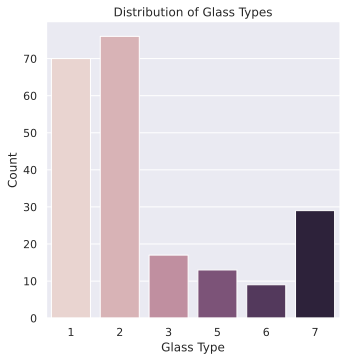

In [ ]:
# Visualize distribution of 'Type_of_glass'
sns.catplot(x='Type_of_glass', hue='Type_of_glass', kind='count', data=df, legend=False)
plt.title('Distribution of Glass Types')
plt.xlabel('Glass Type')
plt.ylabel('Count');

**Дійсно, маємо дісбаланс класів у таргеті.**

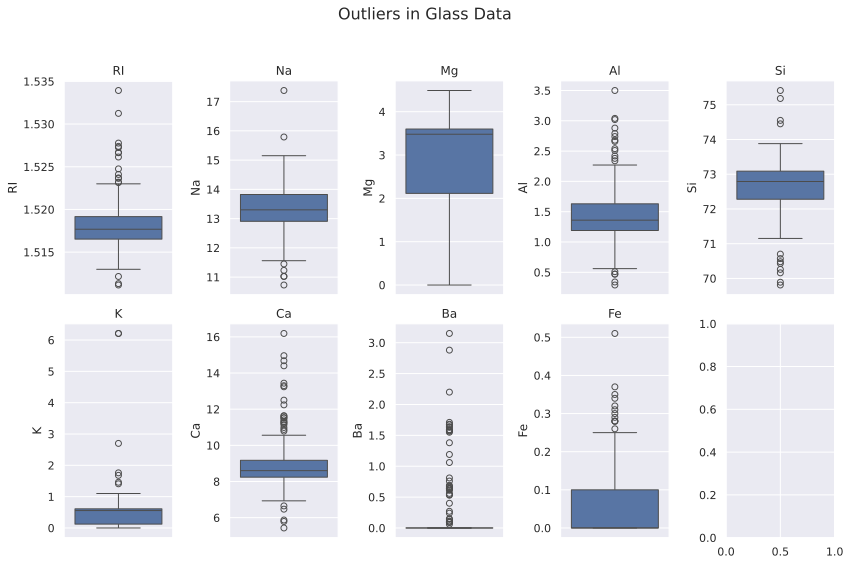

In [ ]:
# Let's check whether the features have outliers
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 8))
fig.suptitle('Outliers in Glass Data', fontsize=16)

# Generate box plots for each column
for i, col in enumerate(df.columns[:-1]):
    sns.boxplot(y=df[col], ax=axes[i//5, i%5])
    axes[i//5, i%5].set_title(col)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**Більшість признаків мають викиди - з видаленням ціх викидів є сенс поекспериментувати.**

## **2. Clean Data and Feature Engineering**

**Ми обмежимося скейлінгом та розділом датасету на train/val/test набіри даних.**

### 2.1. Scale values

In [ ]:
# Separate target
X = df.drop('Type_of_glass', axis=1)
y = df['Type_of_glass']

In [ ]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

### 2.2. Split train/val/test

In [ ]:
# Split data train/test 80/20
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

### 2.3. Visualization of Metrics

In [ ]:
def plot_classification_report(y_true, y_pred, title):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=False)
    classes = list(report.keys())[:-3]
    metrics = ['precision', 'recall', 'f1-score']

    # Write data on class, metric and values
    data = []
    for cls in classes:
        for metric in metrics:
            data.append((cls, metric, report[cls][metric]))

    # Create new dataset for the report
    df = pd.DataFrame(data, columns=['class', 'metric', 'value'])

    # Plot result
    plt.figure(figsize=(10, 6))
    sns.barplot(x='class', y='value', hue='metric', data=df)
    plt.title(title)
    plt.show()

## **3. Build and Fit KNeighborsClassifier**

In [ ]:
# Initialize the classifier
clf_knn = KNeighborsClassifier(algorithm='auto', n_neighbors=7, weights='distance')

In [ ]:
# Fit model on default data
clf_knn.fit(X_train, y_train)
y_prediction_1 = clf_knn.predict(X_test)
test_report_1 = classification_report(y_test, y_prediction_1, digits=3, zero_division=False)

print("Validation Report:\n", test_report_1)

Validation Report:
               precision    recall  f1-score   support

           1      0.625     0.714     0.667        14
           2      0.647     0.733     0.688        15
           3      0.000     0.000     0.000         3
           5      1.000     1.000     1.000         3
           6      0.500     0.500     0.500         2
           7      1.000     0.833     0.909         6

    accuracy                          0.698        43
   macro avg      0.629     0.630     0.627        43
weighted avg      0.662     0.698     0.677        43



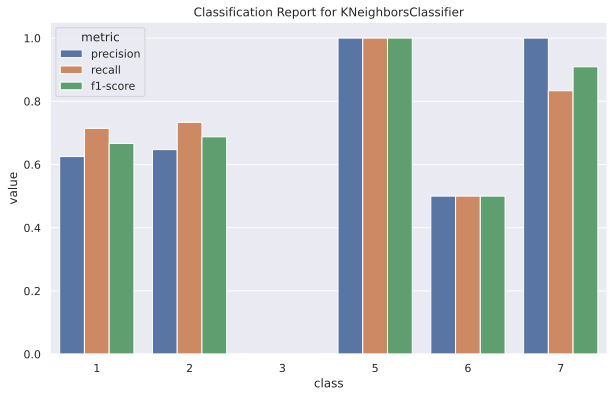

In [ ]:
# Plot classification report for Validation Set
plot_classification_report(y_test, y_prediction_1, 'Classification Report for KNeighborsClassifier')

## **4. Balance Data**

### 4.1. Over-sampling

4.1.1. SMOTEN

In [ ]:
smoten = SMOTEN(random_state=17)
X_smoten, y_smoten = smoten.fit_resample(X_train, y_train)

4.1.2. RandomOverSampler

In [ ]:
ros = RandomOverSampler(random_state=17)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

### 4.2. Under-sampling

4.2.1. TomekLinks

In [ ]:
tl = TomekLinks()
X_tl, y_tl = tl.fit_resample(X_train, y_train)

4.2.2. CondensedNearestNeighbour

In [ ]:
cnn = CondensedNearestNeighbour(random_state=17)
X_cnn, y_cnn = cnn.fit_resample(X_train, y_train)

### 4.3. Combined methods

4.3.1. SMOTEENN

In [ ]:
smoteenn = SMOTEENN(random_state=17)
X_smoteenn, y_smoteenn = smoteenn.fit_resample(X_train, y_train)

4.3.2. SMOTETomek

In [ ]:
smotetomek = SMOTETomek(random_state=17)
X_smotetomek, y_smotetomek = smotetomek.fit_resample(X_train, y_train)


### 4.4. Fit the Model on Balanced Data  

In [ ]:
# Define a function to process repeated operations
def fit_and_report(X_resampled, y_resampled, X_test, y_test, vis_func):
    '''
    Fits KNeighborsClassifier model and generates
    classification report
    '''
    model = KNeighborsClassifier(algorithm='auto', n_neighbors=7, weights='distance')
    model.fit(X_resampled, y_resampled)
    y_pred_resampled = model.predict(X_test)
    vis_func(y_test, y_pred_resampled, "Classification Report")   # plot the classif report

    return classification_report(y_test, y_pred_resampled, output_dict=False, digits=3, zero_division=False)

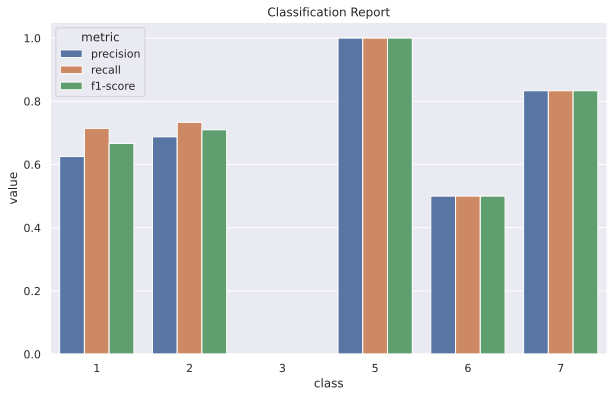

In [ ]:
report_smoten = fit_and_report(X_smoten, y_smoten, X_test, y_test, plot_classification_report)

In [ ]:
print(report_smoten)

              precision    recall  f1-score   support

           1      0.625     0.714     0.667        14
           2      0.688     0.733     0.710        15
           3      0.000     0.000     0.000         3
           5      1.000     1.000     1.000         3
           6      0.500     0.500     0.500         2
           7      0.833     0.833     0.833         6

    accuracy                          0.698        43
   macro avg      0.608     0.630     0.618        43
weighted avg      0.653     0.698     0.674        43



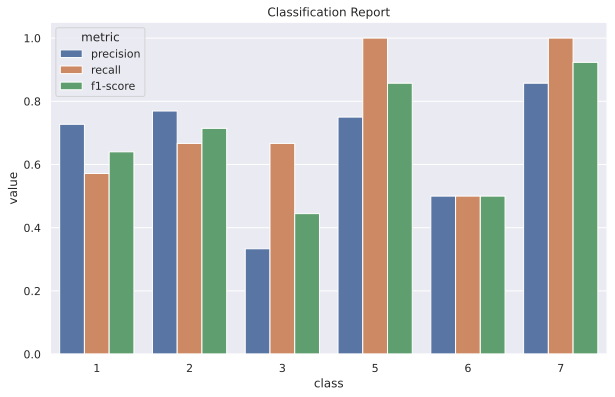

In [ ]:
report_ros = fit_and_report(X_ros, y_ros, X_test, y_test, plot_classification_report)

In [ ]:
print(report_ros)

              precision    recall  f1-score   support

           1      0.727     0.571     0.640        14
           2      0.769     0.667     0.714        15
           3      0.333     0.667     0.444         3
           5      0.750     1.000     0.857         3
           6      0.500     0.500     0.500         2
           7      0.857     1.000     0.923         6

    accuracy                          0.698        43
   macro avg      0.656     0.734     0.680        43
weighted avg      0.724     0.698     0.700        43



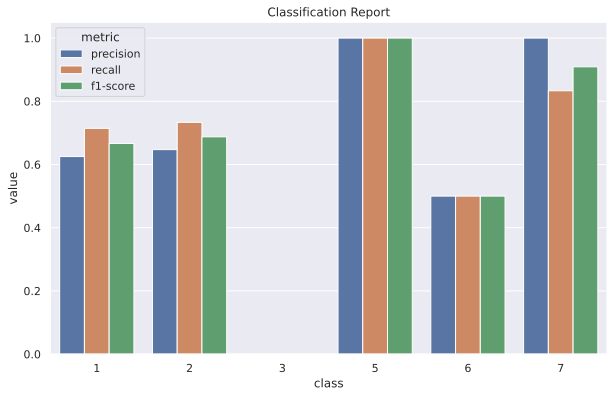

In [ ]:
report_tl = fit_and_report(X_tl, y_tl, X_test, y_test, plot_classification_report)

In [ ]:
print(report_tl)

              precision    recall  f1-score   support

           1      0.625     0.714     0.667        14
           2      0.647     0.733     0.688        15
           3      0.000     0.000     0.000         3
           5      1.000     1.000     1.000         3
           6      0.500     0.500     0.500         2
           7      1.000     0.833     0.909         6

    accuracy                          0.698        43
   macro avg      0.629     0.630     0.627        43
weighted avg      0.662     0.698     0.677        43



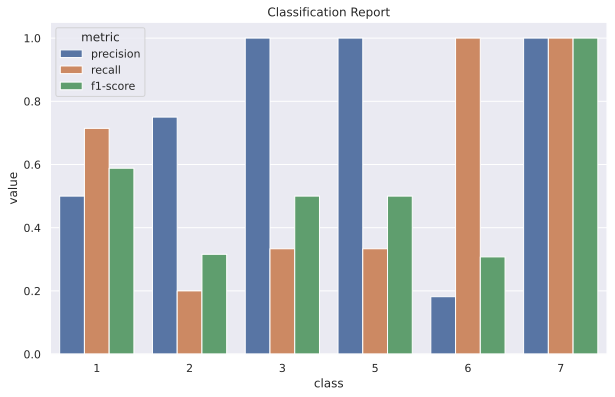

In [ ]:
report_cnn = fit_and_report(X_cnn, y_cnn, X_test, y_test, plot_classification_report)

In [ ]:
print(report_cnn)

              precision    recall  f1-score   support

           1      0.500     0.714     0.588        14
           2      0.750     0.200     0.316        15
           3      1.000     0.333     0.500         3
           5      1.000     0.333     0.500         3
           6      0.182     1.000     0.308         2
           7      1.000     1.000     1.000         6

    accuracy                          0.535        43
   macro avg      0.739     0.597     0.535        43
weighted avg      0.712     0.535     0.525        43



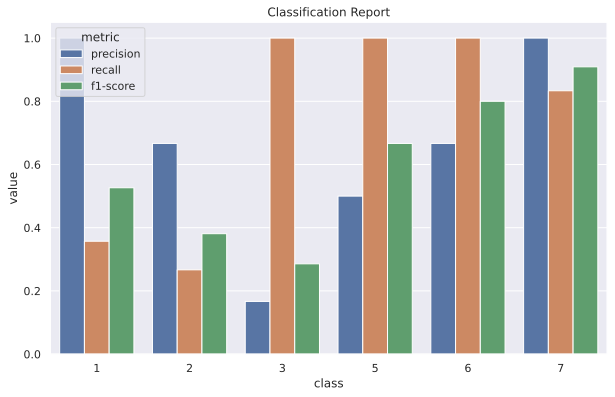

In [ ]:
report_smoteenn = fit_and_report(X_smoteenn, y_smoteenn, X_test, y_test, plot_classification_report)

In [ ]:
print(report_smoteenn)

              precision    recall  f1-score   support

           1      1.000     0.357     0.526        14
           2      0.667     0.267     0.381        15
           3      0.167     1.000     0.286         3
           5      0.500     1.000     0.667         3
           6      0.667     1.000     0.800         2
           7      1.000     0.833     0.909         6

    accuracy                          0.512        43
   macro avg      0.667     0.743     0.595        43
weighted avg      0.775     0.512     0.535        43



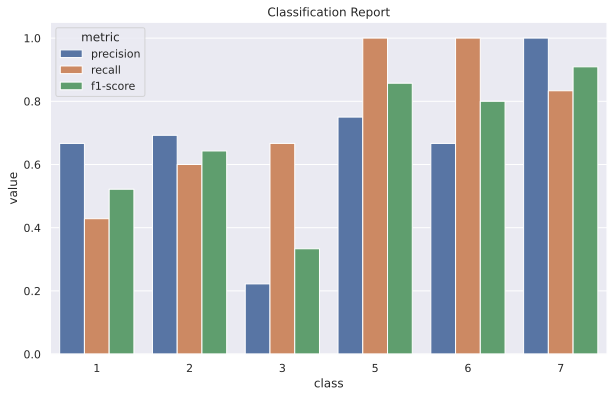

In [ ]:
report_smotetomek = fit_and_report(X_smotetomek, y_smotetomek, X_test, y_test, plot_classification_report)

In [ ]:
print(report_smotetomek)

              precision    recall  f1-score   support

           1      0.667     0.429     0.522        14
           2      0.692     0.600     0.643        15
           3      0.222     0.667     0.333         3
           5      0.750     1.000     0.857         3
           6      0.667     1.000     0.800         2
           7      1.000     0.833     0.909         6

    accuracy                          0.628        43
   macro avg      0.666     0.755     0.677        43
weighted avg      0.697     0.628     0.641        43



### Висновок: найбільш сбалансовані метрики вдалося отримати при використані методу over-sampling ***RandomOverSampler()*** - **weighted avg F1 = 0.70**

In [ ]:
# Combine all reports into a DataFrame for further use (MAKE output_dict=True in fit_and_report() function)
# reports = {
#     'SMOTEN': report_smoten,
#     'RandomOverSampler': report_ros,
#     'TomekLinks': report_tl,
#     'CondensedNearestNeighbour': report_cnn,
#     'SMOTEENN': report_smoteenn,
#     'SMOTETomek': report_smotetomek
# }

# # reports_df = pd.DataFrame(reports).transpose()
# reports_df = pd.DataFrame(reports)

In [ ]:
# reports_df.T.head(6)

,1,2,3,5,6,7,accuracy,macro avg,weighted avg
SMOTEN,"{'precision': 0.625, 'recall': 0.7142857142857...","{'precision': 0.6875, 'recall': 0.733333333333...","{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 1.0, 'recall': 1.0, 'f1-score': ...","{'precision': 0.5, 'recall': 0.5, 'f1-score': ...","{'precision': 0.8333333333333334, 'recall': 0....",0.697674,"{'precision': 0.607638888888889, 'recall': 0.6...","{'precision': 0.6526162790697675, 'recall': 0...."
RandomOverSampler,"{'precision': 0.7272727272727273, 'recall': 0....","{'precision': 0.7692307692307693, 'recall': 0....","{'precision': 0.3333333333333333, 'recall': 0....","{'precision': 0.75, 'recall': 1.0, 'f1-score':...","{'precision': 0.5, 'recall': 0.5, 'f1-score': ...","{'precision': 0.8571428571428571, 'recall': 1....",0.697674,"{'precision': 0.6561632811632812, 'recall': 0....","{'precision': 0.7235613223985317, 'recall': 0...."
TomekLinks,"{'precision': 0.625, 'recall': 0.7142857142857...","{'precision': 0.6470588235294118, 'recall': 0....","{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 1.0, 'recall': 1.0, 'f1-score': ...","{'precision': 0.5, 'recall': 0.5, 'f1-score': ...","{'precision': 1.0, 'recall': 0.833333333333333...",0.697674,"{'precision': 0.6286764705882353, 'recall': 0....","{'precision': 0.6617647058823529, 'recall': 0...."
CondensedNearestNeighbour,"{'precision': 0.5, 'recall': 0.714285714285714...","{'precision': 0.75, 'recall': 0.2, 'f1-score':...","{'precision': 1.0, 'recall': 0.333333333333333...","{'precision': 1.0, 'recall': 0.333333333333333...","{'precision': 0.18181818181818182, 'recall': 1...","{'precision': 1.0, 'recall': 1.0, 'f1-score': ...",0.534884,"{'precision': 0.7386363636363636, 'recall': 0....","{'precision': 0.7119450317124736, 'recall': 0...."
SMOTEENN,"{'precision': 1.0, 'recall': 0.357142857142857...","{'precision': 0.6666666666666666, 'recall': 0....","{'precision': 0.16666666666666666, 'recall': 1...","{'precision': 0.5, 'recall': 1.0, 'f1-score': ...","{'precision': 0.6666666666666666, 'recall': 1....","{'precision': 1.0, 'recall': 0.833333333333333...",0.511628,"{'precision': 0.6666666666666666, 'recall': 0....","{'precision': 0.7751937984496123, 'recall': 0...."
SMOTETomek,"{'precision': 0.6666666666666666, 'recall': 0....","{'precision': 0.6923076923076923, 'recall': 0....","{'precision': 0.2222222222222222, 'recall': 0....","{'precision': 0.75, 'recall': 1.0, 'f1-score':...","{'precision': 0.6666666666666666, 'recall': 1....","{'precision': 1.0, 'recall': 0.833333333333333...",0.627907,"{'precision': 0.6663105413105413, 'recall': 0....","{'precision': 0.6969290399522957, 'recall': 0...."
